# 수화 이미지 CNN으로 분류하기

숫자 사인 한 종류 당 1500장 이미지

한 이미지 당 50x50 픽셀

라이브러리 가져오기

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from keras.preprocessing.image import ImageDataGenerator

구글 드라이브에서 데이터셋 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/NumSignLanguage.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

라벨링

In [ ]:
directory = Path('/content/NumSignLanguage')
filepaths = list(directory.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/NumSignLanguage/7/1089.jpg,7
1,/content/NumSignLanguage/4/1289.jpg,4
2,/content/NumSignLanguage/9/25.jpg,9
3,/content/NumSignLanguage/2/1149.jpg,2
4,/content/NumSignLanguage/6/609.jpg,6


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 15000

Number of different labels: 10

Labels: ['7' '4' '9' '2' '6' '0' '5' '3' '8' '1']


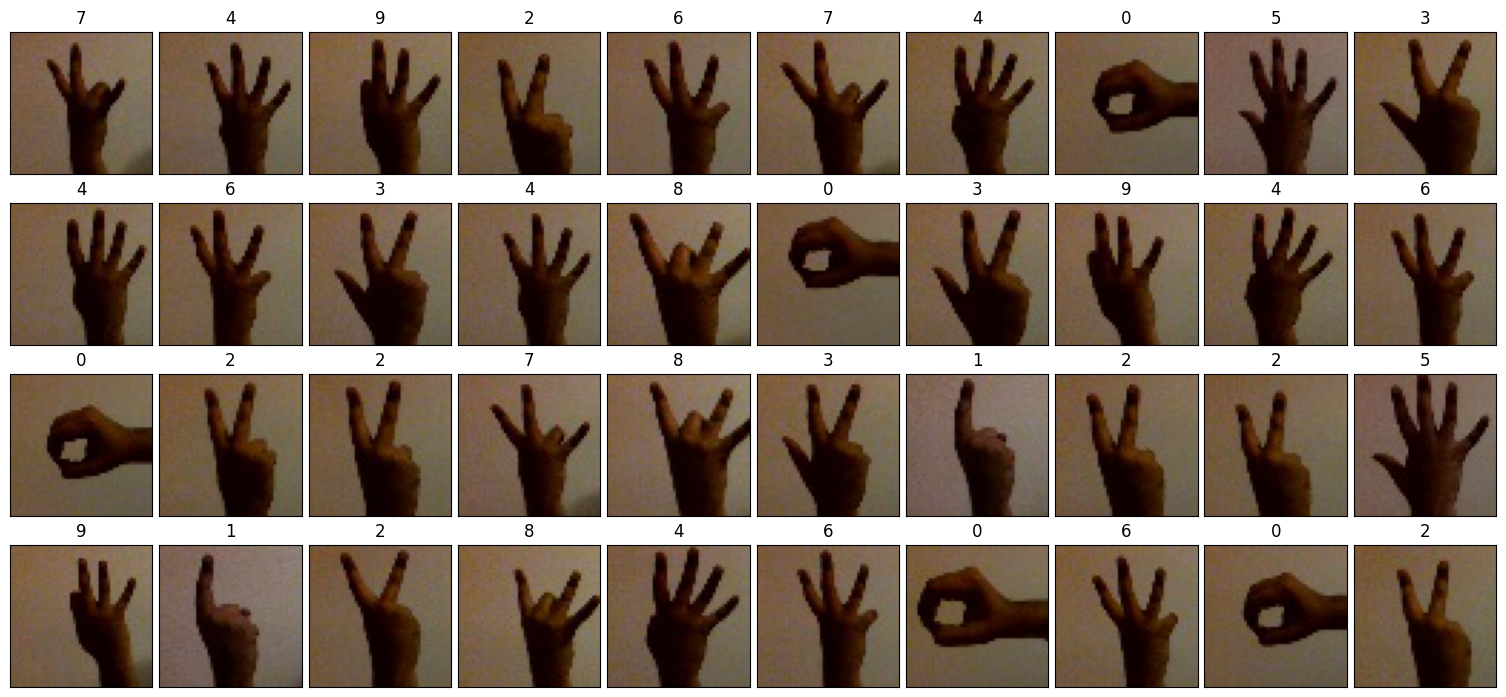

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

이미지를 train, test로 분류

In [ ]:
# Training/test split

train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((13500, 2), (1500, 2))

데이터 전처리(학습시키기 좋은 데이터 만들기)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, #0~1 사이 값으로 normalization. 학습 속도에 영향을 줌
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/NumSignLanguage',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/NumSignLanguage',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 12000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


CNN 모델 구조 정의(기본)

In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=[150, 150, 3])) #값 수정

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax')) #10개로 분류하므로 units=10

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 20736)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 3)

Epoch 1/3
375/375 [==============================] - 182s 484ms/step - loss: 0.2494 - accuracy: 0.9349 - val_loss: 0.0712 - val_accuracy: 0.9823
Epoch 2/3
375/375 [==============================] - 181s 481ms/step - loss: 8.0080e-04 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.9790
Epoch 3/3
375/375 [==============================] - 185s 493ms/step - loss: 2.6848e-04 - accuracy: 1.0000 - val_loss: 0.0823 - val_accuracy: 0.9807


# 데이터셋 개수 1/5로 줄이고 다시 학습

In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/SL.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
dir_ = Path('/content/SL')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/SL/7/92.jpg,7
1,/content/SL/2/197.jpg,2
2,/content/SL/5/94.jpg,5
3,/content/SL/1/38.jpg,1
4,/content/SL/1/47.jpg,1


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 3000

Number of different labels: 10

Labels: ['7' '2' '5' '1' '9' '0' '8' '4' '3' '6']


In [ ]:
# Training/test split

train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((2400, 2), (600, 2))

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, #0~1 사이 값으로 normalization. 학습 속도에 영향을 줌
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/SL',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/SL',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 2400 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax')) #10개로 분류하므로 units=10

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 20736)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 5)

Epoch 1/5
75/75 [==============================] - 38s 498ms/step - loss: 0.6832 - accuracy: 0.8329 - val_loss: 0.1469 - val_accuracy: 0.9367
Epoch 2/5
75/75 [==============================] - 37s 497ms/step - loss: 0.0094 - accuracy: 0.9992 - val_loss: 0.0509 - val_accuracy: 0.9733
Epoch 3/5
75/75 [==============================] - 37s 483ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0359 - val_accuracy: 0.9833
Epoch 4/5
75/75 [==============================] - 35s 463ms/step - loss: 9.3852e-04 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.9867
Epoch 5/5
75/75 [==============================] - 38s 506ms/step - loss: 6.0429e-04 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9867


# ResNet50 사용

In [ ]:
dir_ = Path('/content/SL')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/SL/1/96.jpg,1
1,/content/SL/9/71.jpg,9
2,/content/SL/5/16.jpg,5
3,/content/SL/4/264.jpg,4
4,/content/SL/4/126.jpg,4


In [ ]:
# Training/test split

train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((2400, 2), (600, 2))

In [ ]:
#data augmentarion

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

train_gen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rescale=1.0/255,
        validation_split=0.25
    )
test_gen = ImageDataGenerator(
        rescale=1.0/255,
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

train_generator = train_gen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(50, 50), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방향의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

val_generator = train_gen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50, 50),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

test_generator = test_gen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50, 50),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

Found 1800 validated image filenames belonging to 10 classes.
Found 600 validated image filenames belonging to 10 classes.
Found 600 validated image filenames belonging to 10 classes.


In [ ]:
new_model = ResNet50(weights='imagenet', input_tensor=Input(shape=(50, 50, 3)))

x = new_model.get_layer('avg_pool').output

oputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=new_model.input, outputs=oputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=val_generator)

Epoch 1/5
28/57 [=============>................] - ETA: 2:57 - loss: 0.0375 - accuracy: 0.9911

KeyboardInterrupt: ignored

epoch 1이 16% 진행된 상황에서 이미 accuracy 90% 이상 달성.

굳이 ResNet을 쓰지 않아도 기본적인 CNN만으로도 epoch 3만에 accuracy 100%가 나왔으므로,

시간이 너무 오래 걸리는 ResNet은 쓰지 않는 것이 낫겠다고 판단.

In [ ]:
from google.colab import files
uploaded = files.upload()

샘플 이미지를 학습된 모델에 넣기

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/IMG_20220509_131541.jpg"

test_image = image.load_img(img_path, target_size = (50,50))
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
#test_image = preprocess_input(test_image)
prediction = cnn.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
print(f"## prediction : {(df.iloc[0]['pred'])* 100:.2f}%")

if prediction[0][0] == 1:
  print('Number 0')
elif prediction[0][1] == 1:
  print('Number 1')
elif prediction[0][2] == 1:
  print('Number 2')
elif prediction[0][3] == 1:
  print('Number 3')
elif prediction[0][4] == 1:
  print('Number 4')
elif prediction[0][5] == 1:
  print('Number 5')
elif prediction[0][6] == 1:
  print('Number 6')
elif prediction[0][7] == 1:
  print('Number 7')
elif prediction[0][8] == 1:
  print('Number 8')
elif prediction[0][9] == 1:
  print('Number 9')

# CNN 최종 버전

라이브러리 가져오기

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from keras.preprocessing.image import ImageDataGenerator

구글 드라이브에서 데이터셋 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/SL.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

라벨링

In [ ]:
dir_ = Path('/content/SL')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/SL/1/96.jpg,1
1,/content/SL/9/71.jpg,9
2,/content/SL/5/16.jpg,5
3,/content/SL/4/264.jpg,4
4,/content/SL/4/126.jpg,4


이미지를 train, test로 분류

In [ ]:
# Training/test split

train_df,test_df = train_test_split(df, test_size=0.15,random_state=0)
train_df.shape,test_df.shape

((2550, 2), (450, 2))

데이터 전처리(학습시키기 좋은 데이터 만들기)

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.18)
test_datagen = ImageDataGenerator(rescale=1.0/255,)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50, 50), #사이즈를 (150,150)에서 (50,50)으로 바꿈
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        subset='training',
)

val_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50, 50),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        subset='validation'
    )

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(50,50),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

Found 2091 validated image filenames belonging to 10 classes.
Found 459 validated image filenames belonging to 10 classes.
Found 450 validated image filenames belonging to 10 classes.


CNN 모델 구조 정의

In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=[50, 50, 3])) #사이즈를 (150,150)에서 (50,50)으로 바꿈

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax')) #10개로 분류하므로 units=10

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1936)              0         
                                                                 
 dense (Dense)               (None, 64)                1

학습

In [ ]:
history = cnn.fit(x = train_generator, validation_data = val_generator, epochs = 5)

Epoch 1/5
66/66 [==============================] - 7s 80ms/step - loss: 1.2771 - accuracy: 0.6633 - val_loss: 0.2423 - val_accuracy: 0.9346
Epoch 2/5
66/66 [==============================] - 7s 101ms/step - loss: 0.0903 - accuracy: 0.9837 - val_loss: 0.0270 - val_accuracy: 0.9978
Epoch 3/5
66/66 [==============================] - 4s 63ms/step - loss: 0.0143 - accuracy: 0.9990 - val_loss: 0.0157 - val_accuracy: 0.9978
Epoch 4/5
66/66 [==============================] - 6s 91ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/5
66/66 [==============================] - 4s 66ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000


학습 결과 보여주기(accuracy, loss)

Text(0.5, 1.0, 'Training and validation loss')

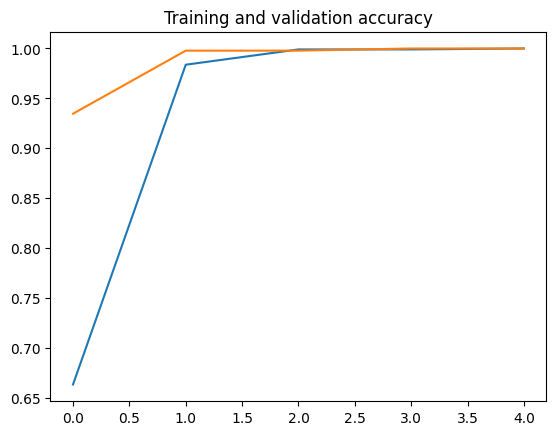

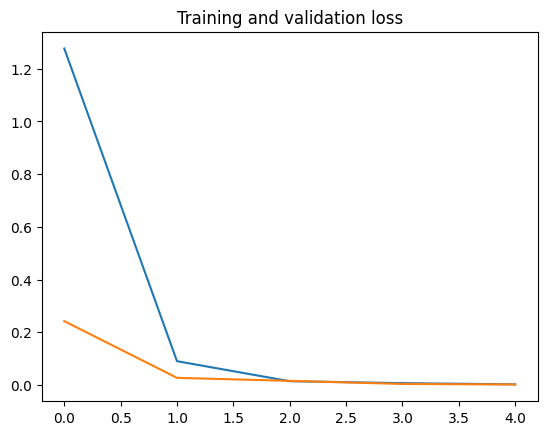

In [ ]:
%matplotlib inline

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

test 데이터셋을 이용한 test loss, test accuracy 확인

In [ ]:
test_loss, test_accuracy = cnn.evaluate(test_generator, batch_size=32)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000
Test Loss:     0.0021642178762704134
Test Accuracy: 1.0


샘플 이미지를 학습된 모델에 넣기

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMG_20220509_131541.jpg to IMG_20220509_131541.jpg


1/1 [==============================] - 0s 28ms/step
## prediction : 100.00%
Number 1


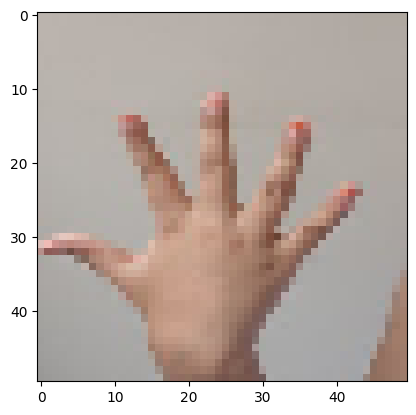

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/IMG_20220509_131541.jpg"

test_image = image.load_img(img_path, target_size = (50,50))
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
#test_image = preprocess_input(test_image)
prediction = cnn.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
print(f"## prediction : {(df.iloc[0]['pred'])* 100:.2f}%")

if prediction[0][0] == 1:
  print('Number 0')
elif prediction[0][1] == 1:
  print('Number 1')
elif prediction[0][2] == 1:
  print('Number 2')
elif prediction[0][3] == 1:
  print('Number 3')
elif prediction[0][4] == 1:
  print('Number 4')
elif prediction[0][5] == 1:
  print('Number 5')
elif prediction[0][6] == 1:
  print('Number 6')
elif prediction[0][7] == 1:
  print('Number 7')
elif prediction[0][8] == 1:
  print('Number 8')
elif prediction[0][9] == 1:
  print('Number 9')